# Lab 02: Credit Rating
## Introduction: 
A credit rating is an evaluation of the risk associated with loaning money or extending credit to a potential debtor. In this case, we are considering credit scores of individual consumers, but credit ratings in general can apply to both individuals or organizations, even entire states and countries. Each observation contains information about a particular banking customer. We assume that these are customers operating in the United States.


In this lab, we will use data orginally designed to predict the balance on credit card, the data for this code is only the training data split from train-tesd data, where the test data is used to grade the model fit to the training data here. In general, we will use a regression model that predicts the credit rating for an individual in the US based on income and demographic information.

## Methods

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from joblib import dump
credit_train = pd.read_csv("https://cs307.org/lab-02/data/credit-train.csv")
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

# Test Statistics

In [6]:
rating_mean = credit_train['Rating'].mean()
rating_std = credit_train['Rating'].std()
student_rating_stats = credit_train.groupby('Student')['Rating'].agg(['mean','std','count'])
marriage_rating_stats = credit_train.groupby('Married')['Rating'].agg(['mean','std','count'])
corr_rating = credit_train[['Rating','Age','Income']].corr()['Rating'].drop('Rating')
a = credit_train.isnull().mean() # search for missing data
rating_mean,rating_std, student_rating_stats, marriage_rating_stats, corr_rating, a

(357.51666666666665,
 157.09976929943386,
                mean         std  count
 Student                               
 No       359.244361  158.383141    266
 Yes      344.100000  146.646267     30,
                mean         std  count
 Married                               
 No       359.389831  154.677389    118
 Yes      358.275281  159.851653    178,
 Age       0.148695
 Income    0.795528
 Name: Rating, dtype: float64,
 Rating       0.000000
 Income       0.146667
 Age          0.096667
 Education    0.070000
 Gender       0.016667
 Student      0.013333
 Married      0.013333
 Ethnicity    0.063333
 dtype: float64)

# Model
We use pipeline, gridsearchCV to ensure robust preprocessing and optimal parameter selection. We use imputation to fill missing value, and data is unmodified.
GridSearchCV plays a pivotal role in this setup by exhaustively searching through a predefined grid of hyperparameters specific to the KNN algorithm, such as the number of neighbors, the weight function used in prediction, and the distance metric for measuring the proximity between instances. This exhaustive search is coupled with cross-validation to evaluate the performance of each parameter combination, thereby ensuring that the selected model is not only tailored to the peculiarities of the training data but also generalizes well to unseen data.The outcome of this process is a finely tuned model encapsulated within the Pipeline, ready to predict outcomes on new data that has the same variable names and types as the training set. This model, referred to as mod in the context of the autograder, is fully equipped with a .predict(X_test) method, allowing for seamless evaluation against a test set with a compatible shape and ensuring adherence to the lab's guidelines for model submission.

In [7]:
X = credit_train.drop('Rating', axis=1)
y = credit_train['Rating']

# Handling categorical and numerical columns separately
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Creating transformers for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Creating a KNN regressor pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

param_grid = {
    'regressor__n_neighbors': [3, 5, 7, 9,11,13],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__metric': ['euclidean', 'manhattan','minkowski', 'chebyshev'],  # Exploring more metrics
    'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Splitting data for cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)

# Saving Results
model_filename = 'credit-ratings.joblib'
dump(grid_search, model_filename)

best_params, best_score

Fitting 5 folds for each of 192 candidates, totalling 960 fits


({'regressor__algorithm': 'kd_tree',
  'regressor__metric': 'chebyshev',
  'regressor__n_neighbors': 13,
  'regressor__weights': 'distance'},
 113.57464125142172)

# Visualization
The plot displays the accuracy of the model across the range of data. Points close to red-dashed line indicate higher accuracy.

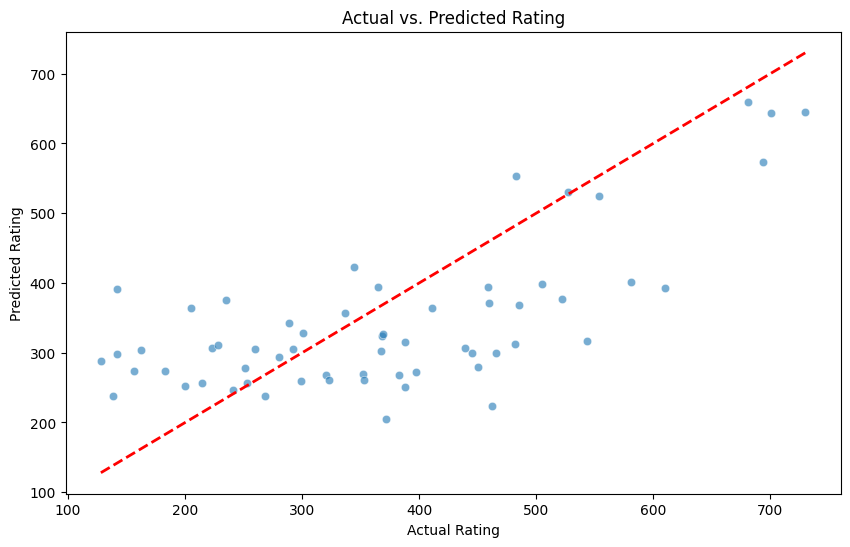

In [8]:
y_pred = grid_search.predict(X_test)
# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs. Predicted Rating')
plt.show()

# Discussion
The use of demographic information to predict credit ratings raises significant ethical and legal questions. Specifically, factors such as age, gender, ethnicity, and marital status could introduce biases that unfairly disadvantage certain groups, leading to discriminatory practices. In the United States, the Equal Credit Opportunity Act (ECOA) prohibits discrimination against applicants on the basis of race, color, religion, national origin, sex, marital status, age, or because they receive public assistance. Therefore, while a model might technically be capable of using such information to predict credit ratings, doing so could violate legal standards and ethical norms.

The model should not be used to predict futuer credit rating. A better law-abiding model can use a detailed feature-analysis incooporated into the machine learning model, while increasing relatability and reliability by reducing reliance on senstive demographic information. 